<a href="https://colab.research.google.com/github/aptr288/Claim_prediction/blob/master/Claim_Prediction_Codebase_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pet Insurance claim prediction.



Libraries downloaded and imported. 


In [0]:
#!pip install pandas

In [0]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive
from google.colab import files
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn import  svm,  tree, metrics
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor 
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

Mounting Google drive to work with files uploaded to Gdrive

In [420]:
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/Trupanion/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading data

Loading Pet data into dataframe

In [421]:
pet_data_df = pd.read_csv('petdata.csv', delimiter=',', header = 'infer')
pet_data_df.head(5)

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old
2,2,2014-12-20,NaN,Dog,French Bulldog,8 weeks to 12 months old
3,3,2015-01-09,2015-01-14,Dog,Mixed Breed,1 year old
4,4,2014-07-20,NaN,Cat,Mixed Breed,8 weeks to 12 months old


Loading Claim data into dataframe

In [422]:
claim_data_df = pd.read_csv('claimdata.csv', delimiter=',', header= 'infer')
claim_data_df.head(5)

,ClaimId,PetId,ClaimDate,ClaimAmount
0,0,9273,2014-02-25,389.65
1,1,1988,2014-03-10,455.40
2,2,2452,2014-04-02,1953.79
3,3,3658,2014-04-05,243.74
4,5,9147,2014-03-18,206.42


Converting dates from string fromat to datetime

In [0]:
pet_data_df['EnrollDate'] =  pd.to_datetime(pet_data_df['EnrollDate'], format='%Y-%m-%d')
pet_data_df['CancelDate'] =  pd.to_datetime(pet_data_df['CancelDate'], format='%Y-%m-%d')
claim_data_df['ClaimDate'] =  pd.to_datetime(claim_data_df['ClaimDate'], format='%Y-%m-%d')

**Joining pet data with claim data, left joined to capture each claim per pet**

In [424]:
claim_data_per_pet = pd.merge(pet_data_df, claim_data_df, how='left' , on = 'PetId')
#replacing Nan value with zero
claim_data_per_pet['ClaimAmount'].fillna(0, inplace=True)
claim_data_per_pet.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old,NaN,NaT,0.00
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old,NaN,NaT,0.00
2,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,7633.0,2018-02-14,82.80
3,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,13987.0,2018-08-07,190.69
4,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,24729.0,2018-04-14,346.61


# Feature Engineering and data cleaning

Extracted features out of exiting ones to better expose the data to train the model.

Total claim amount and claim count for each pet

In [0]:
#User defined function to correct claim count to zero using claim date 
def get_claims_count(ClaimsCount,claim_date):
  if (claim_date is pd.NaT):
    return 0
  else:
    return ClaimsCount

In [426]:
#Total sum of claim amount per pet id
total_claim_amount_per_petid = claim_data_per_pet.groupby('PetId')[['ClaimAmount']].sum()
total_claim_amount_per_petid = total_claim_amount_per_petid.rename(columns = {"PetId": "PetId",  "ClaimAmount": "TotalClaimedAmount"})

#Total count of claims done for each pet id
total_num_cliams_per_petid = claim_data_per_pet.groupby('PetId')[['ClaimAmount']].count()
total_num_cliams_per_petid = total_num_cliams_per_petid.rename(columns = {"PetId": "PetId",  "ClaimAmount": "ClaimsCountIntermediate" })
extracted_features = pd.merge(total_claim_amount_per_petid, total_num_cliams_per_petid, how='inner' , on = 'PetId')
claim_data_per_pet = pd.merge(claim_data_per_pet, extracted_features, how='left' , on = 'PetId')
claim_data_per_pet['ClaimsCountRevised'] = claim_data_per_pet.apply(lambda x: get_claims_count(x.ClaimsCountIntermediate, x.ClaimDate), axis=1)
claim_data_per_pet.drop(['ClaimsCountIntermediate'],inplace=True, axis=1)
extracted_features.drop(['ClaimsCountIntermediate'],inplace=True, axis=1)
#Features extracted are clubed into extracted_features data frame
claims_count_revised = claim_data_per_pet.loc[:, ('PetId', 'ClaimsCountRevised')] #claim_data_per_pet.loc([['PetId', 'ClaimsCountRevised']])
claims_count_revised.drop_duplicates(subset ="PetId", keep = "first", inplace = True)
extracted_features = pd.merge(extracted_features, claims_count_revised, how='inner' , on = 'PetId')
claim_data_per_pet.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount,TotalClaimedAmount,ClaimsCountRevised
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old,NaN,NaT,0.00,0.00,0
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old,NaN,NaT,0.00,0.00,0
2,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,7633.0,2018-02-14,82.80,2643.44,14
3,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,13987.0,2018-08-07,190.69,2643.44,14
4,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,24729.0,2018-04-14,346.61,2643.44,14


Insurance Period, Claim frequency for each month and feature to indicate if insurance is Cancelled 

In [0]:
#Calculate insurance period using enroll date and cancel date or if insurance is not cancelled, then calculte period till given date 2019-07 
def get_insured_period(enrolled,cancelled):
  if (cancelled is pd.NaT):
    return abs(enrolled - pd.Timestamp('2019-07-01')).days
  else:
    return abs(enrolled - cancelled).days

In [428]:
#Number of years insured 
extracted_features['InsurancedPeriod'] = pet_data_df.apply(lambda x: get_insured_period(x.EnrollDate, x.CancelDate)/365, axis=1)
#Frequency of claims per month while insured 
extracted_features['ClaimFreqPerMonth'] = (extracted_features['ClaimsCountRevised']*30)/extracted_features['InsurancedPeriod']
#Feature indicationg if the Insurance is cancelled or not 
extracted_features['InsuranceCancelled'] = pet_data_df['CancelDate'].apply(lambda x: 1 if x is pd.NaT  else 0)
extracted_features.head()

,PetId,TotalClaimedAmount,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled
0,0,0.00,0,2.923288,0.000000,0
1,1,0.00,0,1.942466,0.000000,0
2,2,2643.44,14,4.531507,92.684401,1
3,3,0.00,0,0.013699,0.000000,0
4,4,1356.79,1,4.950685,6.059768,1


In [429]:
#Extract claim year, month and day from datetime object 
claim_data_per_pet['ClaimYear'] = pd.DatetimeIndex(claim_data_per_pet['ClaimDate']).year.fillna(0)
claim_data_per_pet['ClaimMonth'] = pd.DatetimeIndex(claim_data_per_pet['ClaimDate']).month.fillna(0)
claim_data_per_pet['ClaimlDay'] = pd.DatetimeIndex(claim_data_per_pet['ClaimDate']).day.fillna(0)
claim_data_per_pet.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount,TotalClaimedAmount,ClaimsCountRevised,ClaimYear,ClaimMonth,ClaimlDay
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old,NaN,NaT,0.00,0.00,0,0.0,0.0,0.0
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old,NaN,NaT,0.00,0.00,0,0.0,0.0,0.0
2,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,7633.0,2018-02-14,82.80,2643.44,14,2018.0,2.0,14.0
3,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,13987.0,2018-08-07,190.69,2643.44,14,2018.0,8.0,7.0
4,2,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old,24729.0,2018-04-14,346.61,2643.44,14,2018.0,4.0,14.0


In [0]:
#Converting the age at enrolled to years accordingly in numeric 
#['5 years old' '3 years old' '8 weeks to 12 months old' '1 year old', '4 years old' '7 years old' '10 years old' '9 years old' '2 years old', '8 years old' '6 years old' '11 years old' '0-7 weeks old' '13 years old', '12 years old']
def age_conversion_to_numeric(df):
  age_values_at_enrolled = df.AgeAtEnroll.unique()
  # "8 weeks to 12 months old" is converted to 0.5 years approximatly and '0-7 weeks old' to 0.08 years 
  age_converted = [5,3,0.5,1,4,7,10,9,2,8,6,11,0.08,13,12]
  for i in range(len(age_values_at_enrolled)):
    df['AgeAtEnroll'].replace(to_replace = age_values_at_enrolled[i], value = age_converted[i] , inplace=True)

In [0]:
#Calculate the age of pet when claim is registered
def get_age_at_claim(ClaimDate,EnrollDate, AgeAtEnroll):
    if (ClaimDate is pd.NaT):
      #if there is no claim registered then  return the existing age when enrolled 
      return float(AgeAtEnroll)
    else:
     return float((ClaimDate - EnrollDate).days/365 + AgeAtEnroll)

In [432]:
#Age when claim is raised
age_conversion_to_numeric(claim_data_per_pet)
claim_data_per_pet['AgeAtClaim'] = claim_data_per_pet.apply(lambda x: get_age_at_claim(x.ClaimDate, x.EnrollDate, x.AgeAtEnroll), axis=1)
claim_data_per_pet.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,ClaimId,ClaimDate,ClaimAmount,TotalClaimedAmount,ClaimsCountRevised,ClaimYear,ClaimMonth,ClaimlDay,AgeAtClaim
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5.0,NaN,NaT,0.00,0.00,0,0.0,0.0,0.0,5.000000
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3.0,NaN,NaT,0.00,0.00,0,0.0,0.0,0.0,3.000000
2,2,2014-12-20,NaT,Dog,French Bulldog,0.5,7633.0,2018-02-14,82.80,2643.44,14,2018.0,2.0,14.0,3.656164
3,2,2014-12-20,NaT,Dog,French Bulldog,0.5,13987.0,2018-08-07,190.69,2643.44,14,2018.0,8.0,7.0,4.132877
4,2,2014-12-20,NaT,Dog,French Bulldog,0.5,24729.0,2018-04-14,346.61,2643.44,14,2018.0,4.0,14.0,3.817808


#Grouped data by month of year for each petId(Total Claim amount for whole month)

In [433]:
#Grouping data by month of each year for every petId to get sum of all the claim amount raised in each particular month of year for every petid
claim_data_per_pet_month = claim_data_per_pet.groupby(['PetId','ClaimYear','ClaimMonth'], as_index=False)[['ClaimAmount']].sum()
#getting mean of age 
claim_data_per_pet_month['AgeAtClaim']= claim_data_per_pet.groupby(['PetId','ClaimYear','ClaimMonth'], as_index=False)[['AgeAtClaim']].mean()['AgeAtClaim']
claim_data_per_pet_month.head(20)

,PetId,ClaimYear,ClaimMonth,ClaimAmount,AgeAtClaim
0,0,0.0,0.0,0.00,5.000000
1,1,0.0,0.0,0.00,3.000000
2,2,2015.0,12.0,75.32,1.527397
3,2,2016.0,1.0,61.06,1.552055
4,2,2017.0,6.0,63.25,2.954795
5,2,2017.0,7.0,144.12,3.080822
6,2,2017.0,11.0,265.93,3.447945
7,2,2017.0,12.0,567.32,3.461644
8,2,2018.0,2.0,82.80,3.656164
9,2,2018.0,4.0,346.61,3.817808


In [434]:
#Merging all other features with per month data
claim_data_per_pet_month = pd.merge(claim_data_per_pet_month, extracted_features, how='left' , on = 'PetId')
claim_data_per_pet_month = pd.merge(claim_data_per_pet_month, pet_data_df, how='left' , on = 'PetId')
claim_data_per_pet_month.head()

,PetId,ClaimYear,ClaimMonth,ClaimAmount,AgeAtClaim,TotalClaimedAmount,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
0,0,0.0,0.0,0.00,5.000000,0.00,0,2.923288,0.000000,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5 years old
1,1,0.0,0.0,0.00,3.000000,0.00,0,1.942466,0.000000,0,2014-02-15,2016-01-25,Cat,Mixed Breed,3 years old
2,2,2015.0,12.0,75.32,1.527397,2643.44,14,4.531507,92.684401,1,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old
3,2,2016.0,1.0,61.06,1.552055,2643.44,14,4.531507,92.684401,1,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old
4,2,2017.0,6.0,63.25,2.954795,2643.44,14,4.531507,92.684401,1,2014-12-20,NaT,Dog,French Bulldog,8 weeks to 12 months old


In [435]:
#Extracting Enrollment and Cancellation year, month and day from datetime objects 
claim_data_per_pet_month['EnrollYear'] = pd.DatetimeIndex(claim_data_per_pet_month['EnrollDate']).year
claim_data_per_pet_month['EnrollMonth'] = pd.DatetimeIndex(claim_data_per_pet_month['EnrollDate']).month
claim_data_per_pet_month['EnrollDay'] = pd.DatetimeIndex(claim_data_per_pet_month['EnrollDate']).day
claim_data_per_pet_month['CancelYear'] = pd.DatetimeIndex(claim_data_per_pet_month['CancelDate']).year
claim_data_per_pet_month['CancelMonth'] = pd.DatetimeIndex(claim_data_per_pet_month['CancelDate']).month
claim_data_per_pet_month['CancelDay'] = pd.DatetimeIndex(claim_data_per_pet_month['CancelDate']).day
age_conversion_to_numeric(claim_data_per_pet_month)
claim_data_per_pet_month.head()

,PetId,ClaimYear,ClaimMonth,ClaimAmount,AgeAtClaim,TotalClaimedAmount,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,EnrollYear,EnrollMonth,EnrollDay,CancelYear,CancelMonth,CancelDay
0,0,0.0,0.0,0.00,5.000000,0.00,0,2.923288,0.000000,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5.0,2015,8,11,2018.0,7.0,13.0
1,1,0.0,0.0,0.00,3.000000,0.00,0,1.942466,0.000000,0,2014-02-15,2016-01-25,Cat,Mixed Breed,3.0,2014,2,15,2016.0,1.0,25.0
2,2,2015.0,12.0,75.32,1.527397,2643.44,14,4.531507,92.684401,1,2014-12-20,NaT,Dog,French Bulldog,0.5,2014,12,20,NaN,NaN,NaN
3,2,2016.0,1.0,61.06,1.552055,2643.44,14,4.531507,92.684401,1,2014-12-20,NaT,Dog,French Bulldog,0.5,2014,12,20,NaN,NaN,NaN
4,2,2017.0,6.0,63.25,2.954795,2643.44,14,4.531507,92.684401,1,2014-12-20,NaT,Dog,French Bulldog,0.5,2014,12,20,NaN,NaN,NaN


# Encoding feature data 

In [436]:
# process columns, apply LabelEncoder to categorical features
# cols = ['Species', 'Breed']
# for c in cols:
#     lbl = LabelEncoder() 
#     lbl.fit(list(claim_data_per_pet_month[c].values)) 
#     claim_data_per_pet_month[c] = lbl.transform(list(claim_data_per_pet_month[c].values))
# claim_data_per_pet_month.head()

#preferred one_hot_encoding over lable encoding for features with less unique values
def one_hot_encoding_func(df):
  cols = ['Species', 'Breed']
  for c in cols:
    endcoded_columns = pd.get_dummies(df[c])
    df = df.drop(c,axis = 1)
    df = df.join(endcoded_columns)
  return df
claim_data_per_pet_month = one_hot_encoding_func(claim_data_per_pet_month)
print("Column list with added new features => \n {}".format(claim_data_per_pet_month.columns))

Column list with added new features => 
 Index(['PetId', 'ClaimYear', 'ClaimMonth', 'ClaimAmount', 'AgeAtClaim',
       'TotalClaimedAmount', 'ClaimsCountRevised', 'InsurancedPeriod',
       'ClaimFreqPerMonth', 'InsuranceCancelled', 'EnrollDate', 'CancelDate',
       'AgeAtEnroll', 'EnrollYear', 'EnrollMonth', 'EnrollDay', 'CancelYear',
       'CancelMonth', 'CancelDay', 'Cat', 'Dog', 'Chihuahua', 'French Bulldog',
       'Golden Retriever', 'Great Dane', 'Mixed Breed', 'Ragdoll'],
      dtype='object')


# Feature Selection

In [437]:
#Selecting features from whole set of existing columns
selected_features = ['ClaimYear', 'ClaimMonth', 'AgeAtClaim',
       'TotalClaimedAmount', 'ClaimsCountRevised', 'InsurancedPeriod',
       'ClaimFreqPerMonth', 'InsuranceCancelled',
       'AgeAtEnroll', 'EnrollYear', 'EnrollMonth',  'CancelYear',
       'CancelMonth',  'Cat', 'Dog', 'Chihuahua', 'French Bulldog',
       'Golden Retriever', 'Great Dane', 'Mixed Breed', 'Ragdoll' ]
selected_features.append('ClaimAmount')

final_features_selected = claim_data_per_pet_month[selected_features]
final_features_selected.head()

,ClaimYear,ClaimMonth,AgeAtClaim,TotalClaimedAmount,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled,AgeAtEnroll,EnrollYear,EnrollMonth,CancelYear,CancelMonth,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,Mixed Breed,Ragdoll,ClaimAmount
0,0.0,0.0,5.000000,0.00,0,2.923288,0.000000,0,5.0,2015,8,2018.0,7.0,0,1,0,0,0,0,1,0,0.00
1,0.0,0.0,3.000000,0.00,0,1.942466,0.000000,0,3.0,2014,2,2016.0,1.0,1,0,0,0,0,0,1,0,0.00
2,2015.0,12.0,1.527397,2643.44,14,4.531507,92.684401,1,0.5,2014,12,NaN,NaN,0,1,0,1,0,0,0,0,75.32
3,2016.0,1.0,1.552055,2643.44,14,4.531507,92.684401,1,0.5,2014,12,NaN,NaN,0,1,0,1,0,0,0,0,61.06
4,2017.0,6.0,2.954795,2643.44,14,4.531507,92.684401,1,0.5,2014,12,NaN,NaN,0,1,0,1,0,0,0,0,63.25


In [438]:
#Imputing zeros with Nan value
final_features_selected = final_features_selected.fillna(0)
#Alternative approach yet to be tested
final_features_selected_None = final_features_selected.fillna('None')
cols = ['CancelYear', 'CancelMonth', 'ClaimYear', 'ClaimMonth' ]
#casting the columns 
for i in cols:
  final_features_selected[i] = final_features_selected[i].astype(int)
final_features_selected.head()

,ClaimYear,ClaimMonth,AgeAtClaim,TotalClaimedAmount,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled,AgeAtEnroll,EnrollYear,EnrollMonth,CancelYear,CancelMonth,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,Mixed Breed,Ragdoll,ClaimAmount
0,0,0,5.000000,0.00,0,2.923288,0.000000,0,5.0,2015,8,2018,7,0,1,0,0,0,0,1,0,0.00
1,0,0,3.000000,0.00,0,1.942466,0.000000,0,3.0,2014,2,2016,1,1,0,0,0,0,0,1,0,0.00
2,2015,12,1.527397,2643.44,14,4.531507,92.684401,1,0.5,2014,12,0,0,0,1,0,1,0,0,0,0,75.32
3,2016,1,1.552055,2643.44,14,4.531507,92.684401,1,0.5,2014,12,0,0,0,1,0,1,0,0,0,0,61.06
4,2017,6,2.954795,2643.44,14,4.531507,92.684401,1,0.5,2014,12,0,0,0,1,0,1,0,0,0,0,63.25


# Visualizing Data (Correlation)

Visulaizing the data correlation to determin which 

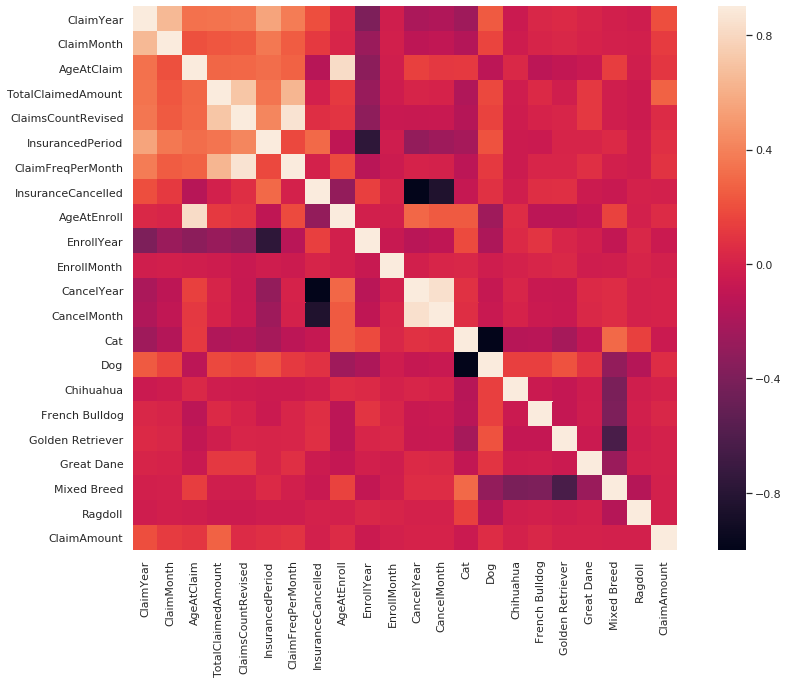

In [439]:
#claim_amount correlation matrix
corrmat = final_features_selected.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corrmat, vmax=0.9, square=True)

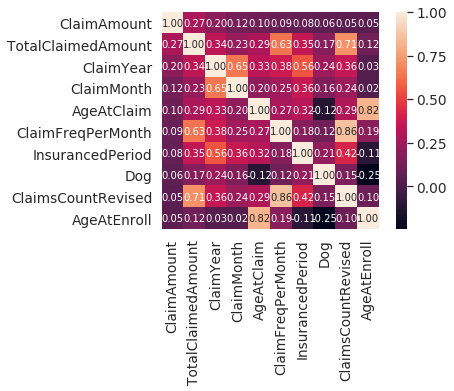

In [440]:

corrmat = final_features_selected.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'ClaimAmount')['ClaimAmount'].index
cm = np.corrcoef(final_features_selected[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

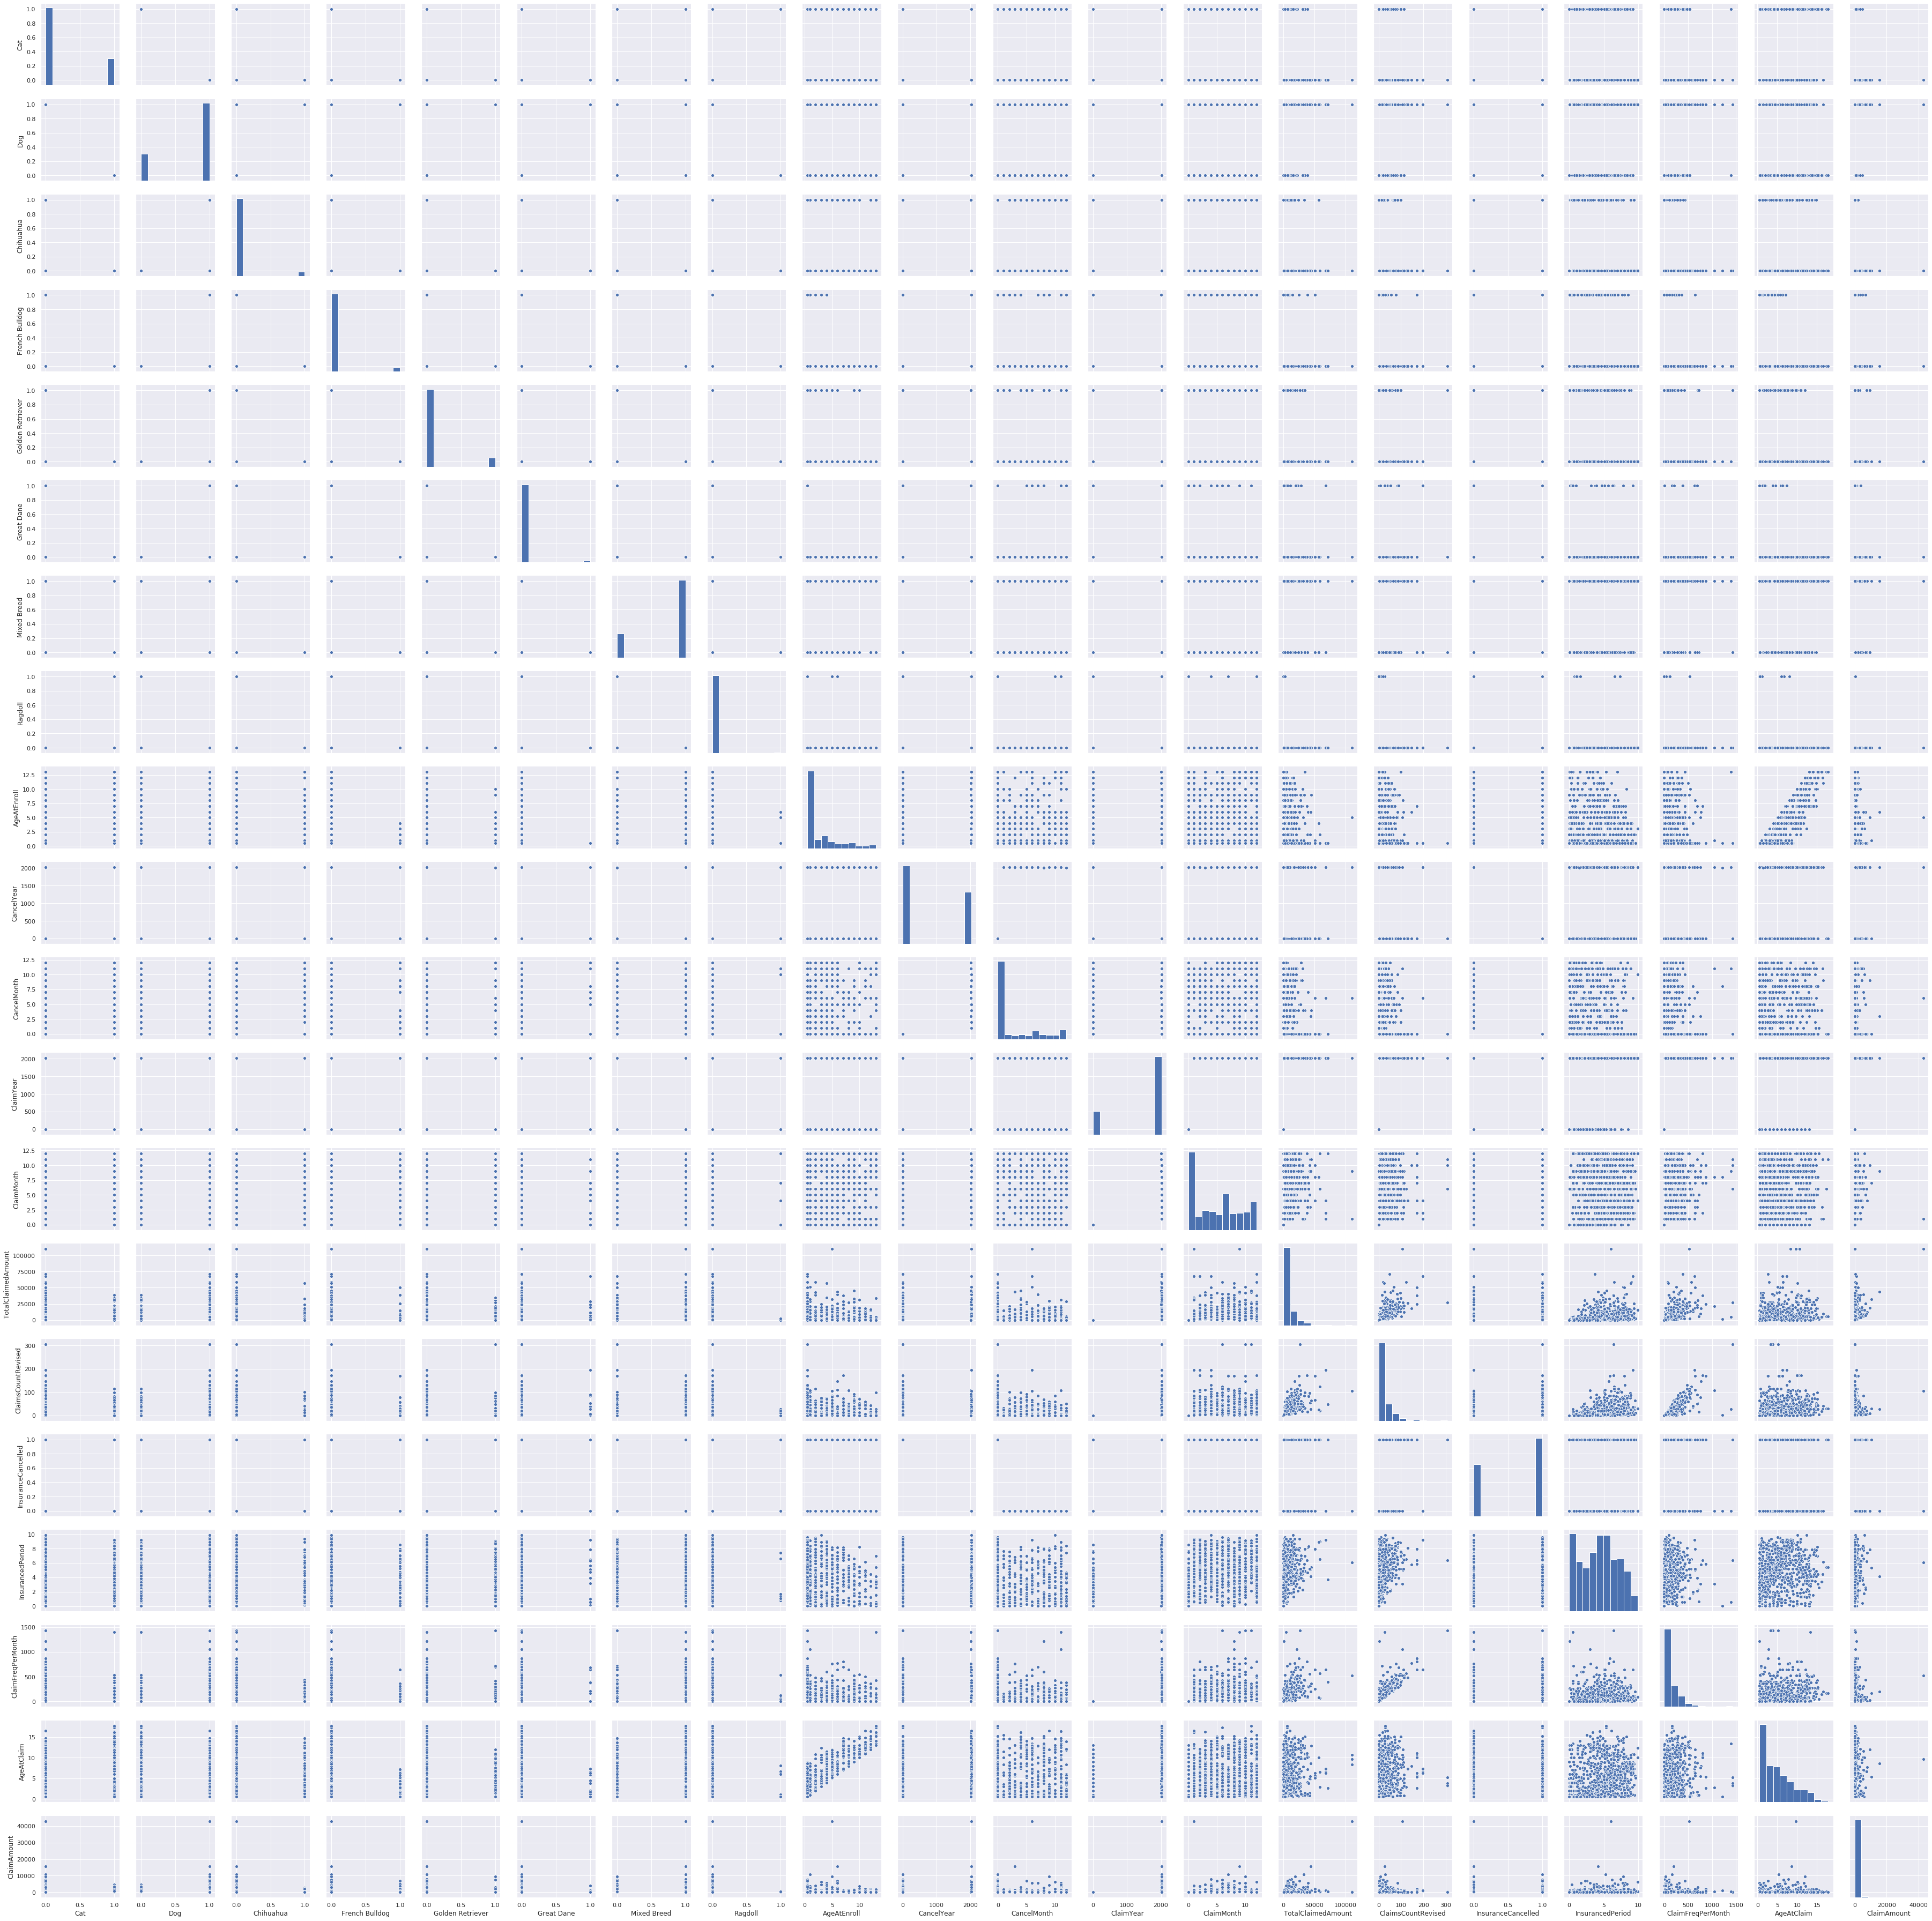

In [378]:
#Data distribution display
sns.set()
cols = ['Cat', 'Dog', 'Chihuahua', 'French Bulldog', 'Golden Retriever', 'Great Dane', 'Mixed Breed', 'Ragdoll', 'AgeAtEnroll', 	'CancelYear',	'CancelMonth',		'ClaimYear',	'ClaimMonth',  'TotalClaimedAmount', 'ClaimsCountRevised', 'InsuranceCancelled', 'InsurancedPeriod' , 'ClaimFreqPerMonth', 'AgeAtClaim', 'ClaimAmount' ]
sns.pairplot(final_features_selected[cols].sample(1000), height = 2.5)
plt.show();

Feature and Label 

In [0]:
y =final_features_selected['ClaimAmount']
#selected_features = [ 'AgeAtEnroll', 	'CancelYear',	'CancelMonth', 'ClaimYear',	'ClaimMonth',  'TotalClaimedAmount', 'ClaimsCountRevised', 'InsuranceCancelled', 'InsurancedPeriod' , 'ClaimFreqPerMonth', 'AgeAtClaim' ]
#X = final_features_selected[selected_features]
X = final_features_selected.drop(['ClaimAmount'], axis=1)


In [0]:
#train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
# Normalizing the dataset to make sure all the data is in range of 0 to 1 
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_rescaled = X_train #scaler.fit_transform(X_train)
X_test_rescaled = X_test #scaler.fit_transform(X_test)

# Model Training

In [445]:
regressor = LinearRegression()  
regressor.fit(X_train_rescaled, y_train)
y_pred_linear_reg = regressor.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_linear_reg))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_linear_reg))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear_reg)))

Mean Absolute Error: 561.2863568565641
Mean Squared Error: 1643853.043074919
Root Mean Squared Error: 1282.1283255099386


In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [0]:
# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train_rescaled, y_train)

In [0]:
# rf_random.best_params_
# best_random = rf_random.best_estimator_

In [446]:
randomForest = RandomForestRegressor()
randomForest.fit(X_train_rescaled, y_train)
ydecpredRand = randomForest.predict(X_test_rescaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ydecpredRand))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ydecpredRand))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ydecpredRand)))

Mean Absolute Error: 522.618890287707
Mean Squared Error: 1681553.2291180652
Root Mean Squared Error: 1296.7471723964024


In [346]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train_rescaled.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2816      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 167,681
Trainable params: 167,681
Non-trainable params: 0
_________________________________________________________________


In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [348]:
NN_model.fit(X_train_rescaled, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)




Train on 18350 samples, validate on 4588 samples
Epoch 1/500





18350/18350 [==============================] - 12s 656us/step - loss: 437.2843 - mean_absolute_error: 437.2843 - val_loss: 448.1083 - val_mean_absolute_error: 448.1083

Epoch 00001: val_loss improved from inf to 448.10832, saving model to Weights-001--448.10832.hdf5
Epoch 2/500
18350/18350 [==============================] - 3s 148us/step - loss: 430.1794 - mean_absolute_error: 430.1794 - val_loss: 449.4816 - val_mean_absolute_error: 449.4816

Epoch 00002: val_loss did not improve from 448.10832
Epoch 3/500
18350/18350 [==============================] - 3s 147us/step - loss: 425.2654 - mean_absolute_error: 425.2654 - val_loss: 447.5316 - val_mean_absolute_error: 447.5316

Epoch 00003: val_loss improved from 448.10832 to 447.53165, saving model to Weights-003--447.53165.hdf5
Epoch 4/500
18350/18350 [==============================] - 3s 151us/step - loss: 424.4789 - mean_absolute_error: 424.4789 - val_loss: 434.5516 - va

In [349]:
destree = tree.DecisionTreeRegressor()
destree.fit(X_train_rescaled, y_train)
ydecpredTree = destree.predict(X_test_rescaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ydecpredTree))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ydecpredTree))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ydecpredTree)))

Mean Absolute Error: 627.8023801220576
Mean Squared Error: 2754524.1600601044
Root Mean Squared Error: 1659.6759201904763


In [447]:
model = xgb.XGBRegressor()
model.fit(X_train_rescaled, y_train)
ypred_xgb_reg_pred = model.predict(X_test_rescaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ypred_xgb_reg_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ypred_xgb_reg_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ypred_xgb_reg_pred)))

[06:50:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Mean Absolute Error: 480.46556138852293
Mean Squared Error: 1417115.21898575
Root Mean Squared Error: 1190.426486174493


[0.1052748  0.1341452  0.02824425 0.17045401 0.254122   0.05308104
 0.02610499 0.04306822 0.11800931 0.03867282 0.00454549 0.00140582
 0.02287197 0.         0.         0.         0.         0.
 0.         0.         0.        ]


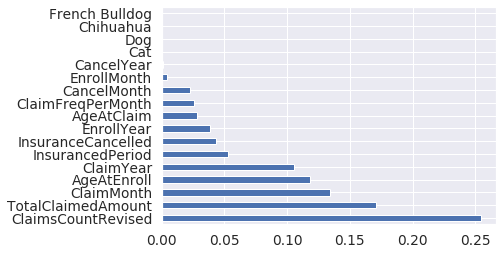

In [351]:
print(model.feature_importances_)
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(17)
   .plot(kind='barh'))

In [448]:
gradBoost = GradientBoostingRegressor()
gradBoost.fit(X_train_rescaled, y_train)
ydecpredRand = gradBoost.predict(X_test_rescaled)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, ydecpredRand))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, ydecpredRand))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, ydecpredRand)))


Mean Absolute Error: 480.9551238603649
Mean Squared Error: 1397888.8033137582
Root Mean Squared Error: 1182.3234765975674


# Test data preprocessing

In [449]:
pet_data_test = pd.merge(pet_data_df, extracted_features, how='inner' , on = 'PetId')
age_conversion_to_numeric(pet_data_test)
pet_data_test.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,TotalClaimedAmount,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5.0,0.00,0,2.923288,0.000000,0
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3.0,0.00,0,1.942466,0.000000,0
2,2,2014-12-20,NaT,Dog,French Bulldog,0.5,2643.44,14,4.531507,92.684401,1
3,3,2015-01-09,2015-01-14,Dog,Mixed Breed,1.0,0.00,0,0.013699,0.000000,0
4,4,2014-07-20,NaT,Cat,Mixed Breed,0.5,1356.79,1,4.950685,6.059768,1


In [0]:
#Calculate the age of pet when claim is registered
def get_age_at_claim_test(ClaimDate,EnrollDate, AgeAtEnroll):
     return float((ClaimDate - EnrollDate).days/365 + AgeAtEnroll)

In [452]:
pet_data_test['EnrollYear'] = pd.DatetimeIndex(pet_data_test['EnrollDate']).year
pet_data_test['EnrollMonth'] = pd.DatetimeIndex(pet_data_test['EnrollDate']).month
pet_data_test['EnrollDay'] = pd.DatetimeIndex(pet_data_test['EnrollDate']).day
pet_data_test['CancelYear'] = pd.DatetimeIndex(pet_data_test['CancelDate']).year
pet_data_test['CancelMonth'] = pd.DatetimeIndex(pet_data_test['CancelDate']).month
pet_data_test['CancelDay'] = pd.DatetimeIndex(pet_data_test['CancelDate']).day
pet_data_test['ClaimYear'] = '2019'
pet_data_test['ClaimMonth'] = '07'
pet_data_test['AgeAtClaim'] = pet_data_test.apply(lambda x: get_age_at_claim_test(pd.Timestamp('2019-07-01'), x.EnrollDate, x.AgeAtEnroll), axis=1)
pet_data_test.head()

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,TotalClaimedAmount,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled,EnrollYear,EnrollMonth,EnrollDay,CancelYear,CancelMonth,CancelDay,ClaimYear,ClaimMonth,AgeAtClaim
0,0,2015-08-11,2018-07-13,Dog,Mixed Breed,5.0,0.00,0,2.923288,0.000000,0,2015,8,11,2018.0,7.0,13.0,2019,07,8.890411
1,1,2014-02-15,2016-01-25,Cat,Mixed Breed,3.0,0.00,0,1.942466,0.000000,0,2014,2,15,2016.0,1.0,25.0,2019,07,8.375342
2,2,2014-12-20,NaT,Dog,French Bulldog,0.5,2643.44,14,4.531507,92.684401,1,2014,12,20,NaN,NaN,NaN,2019,07,5.031507
3,3,2015-01-09,2015-01-14,Dog,Mixed Breed,1.0,0.00,0,0.013699,0.000000,0,2015,1,9,2015.0,1.0,14.0,2019,07,5.476712
4,4,2014-07-20,NaT,Cat,Mixed Breed,0.5,1356.79,1,4.950685,6.059768,1,2014,7,20,NaN,NaN,NaN,2019,07,5.450685


In [453]:
pet_data_test = one_hot_encoding_func(pet_data_test)
pet_data_test.head()

,PetId,EnrollDate,CancelDate,AgeAtEnroll,TotalClaimedAmount,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled,EnrollYear,EnrollMonth,EnrollDay,CancelYear,CancelMonth,CancelDay,ClaimYear,ClaimMonth,AgeAtClaim,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,Mixed Breed,Ragdoll
0,0,2015-08-11,2018-07-13,5.0,0.00,0,2.923288,0.000000,0,2015,8,11,2018.0,7.0,13.0,2019,07,8.890411,0,1,0,0,0,0,1,0
1,1,2014-02-15,2016-01-25,3.0,0.00,0,1.942466,0.000000,0,2014,2,15,2016.0,1.0,25.0,2019,07,8.375342,1,0,0,0,0,0,1,0
2,2,2014-12-20,NaT,0.5,2643.44,14,4.531507,92.684401,1,2014,12,20,NaN,NaN,NaN,2019,07,5.031507,0,1,0,1,0,0,0,0
3,3,2015-01-09,2015-01-14,1.0,0.00,0,0.013699,0.000000,0,2015,1,9,2015.0,1.0,14.0,2019,07,5.476712,0,1,0,0,0,0,1,0
4,4,2014-07-20,NaT,0.5,1356.79,1,4.950685,6.059768,1,2014,7,20,NaN,NaN,NaN,2019,07,5.450685,1,0,0,0,0,0,1,0


In [454]:
# process columns, apply LabelEncoder to categorical features
petId = pet_data_test['PetId']
selected_features.remove('ClaimAmount')
pet_data_test_final = pet_data_test[selected_features]
pet_data_test_final = pet_data_test_final.fillna(0)
pet_data_test_final['CancelYear'] = pet_data_test_final['CancelYear'].astype(int)
pet_data_test_final['CancelMonth'] = pet_data_test_final['CancelMonth'].astype(int)
pet_data_test_final['ClaimYear'] = pet_data_test_final['ClaimYear'].astype(int)
pet_data_test_final['ClaimMonth'] = pet_data_test_final['ClaimMonth'].astype(int)
pet_data_test_final.head()

,ClaimYear,ClaimMonth,AgeAtClaim,TotalClaimedAmount,ClaimsCountRevised,InsurancedPeriod,ClaimFreqPerMonth,InsuranceCancelled,AgeAtEnroll,EnrollYear,EnrollMonth,CancelYear,CancelMonth,Cat,Dog,Chihuahua,French Bulldog,Golden Retriever,Great Dane,Mixed Breed,Ragdoll
0,2019,7,8.890411,0.00,0,2.923288,0.000000,0,5.0,2015,8,2018,7,0,1,0,0,0,0,1,0
1,2019,7,8.375342,0.00,0,1.942466,0.000000,0,3.0,2014,2,2016,1,1,0,0,0,0,0,1,0
2,2019,7,5.031507,2643.44,14,4.531507,92.684401,1,0.5,2014,12,0,0,0,1,0,1,0,0,0,0
3,2019,7,5.476712,0.00,0,0.013699,0.000000,0,1.0,2015,1,2015,1,0,1,0,0,0,0,1,0
4,2019,7,5.450685,1356.79,1,4.950685,6.059768,1,0.5,2014,7,0,0,1,0,0,0,0,0,1,0


In [460]:
ypred_gradBoost = gradBoost.predict(pet_data_test_final)
print(ypred_gradBoost)

[ 192.22326719  176.34186619  262.92259696 ...  160.92143167 1548.81440323
  177.70902928]


In [0]:
ypred_nn = NN_model.predict(pet_data_test_final)
ypred_nn = [i[0] for i in ypred_nn]

In [0]:
submission = pd.DataFrame({
        "petId": petId,
        "CliamAmount": ypred_nn
    })
submission.to_csv('Pet_claim_predicted_july.csv', index=False)